In [1]:
# Data Manipulation & Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Binary & Serialization
import binascii
import joblib

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

# Dimensionality Reduction
from sklearn.decomposition import PCA

# Clustering
from sklearn.cluster import KMeans, DBSCAN

# Model Selection
from sklearn.model_selection import train_test_split, cross_val_score

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Evaluation Metrics
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Deep Learning (Keras / TensorFlow)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Plotting Settings
%matplotlib inline
sns.set_theme(style="whitegrid")


In [2]:
import gc

gc.collect()  # force garbage collection


4

In [3]:
df = pd.read_csv("E:/VE_project/datasets/v2.csv", parse_dates=['timeStamp'],low_memory=False)
df.head()


,tripID,deviceID,timeStamp,accData,gps_speed,battery,cTemp,dtc,eLoad,iat,imap,kpl,maf,rpm,speed,tAdv,tPos
0,1,0.0,2017-12-22 18:43:05,10c0f8e00448fa18c80515d30000000000000000000000...,24.2612,0.0,66.0,0.0,28.6275,40.0,97.0,0.0,0.0,1010.75,23.0,0.0,0.0
1,1,0.0,2017-12-22 18:43:06,1138f8c804780a1ebdf718bcf919d10617c8e301b31017...,23.15,0.0,66.0,0.0,33.7255,40.0,98.0,0.0,0.0,815.5,21.0,0.0,0.0
2,1,0.0,2017-12-22 18:43:07,10f0f89804480612c30010c30714ce0520b7f41dbdf118...,18.7052,0.0,66.0,0.0,43.1373,40.0,98.0,0.0,0.0,862.25,17.0,0.0,0.0
3,1,0.0,2017-12-22 18:43:08,10d0f84804480d15bd0210c9f822c80017caf81ccd0517...,16.4828,0.0,66.0,0.0,41.5686,40.0,97.0,0.0,0.0,817.0,17.0,0.0,0.0
4,1,0.0,2017-12-22 18:43:09,1090f8c80480041dc9081cc50815c60511c60112c40514...,17.4088,0.0,66.0,0.0,43.1373,40.0,97.0,0.0,0.0,804.25,15.0,0.0,0.0


In [5]:
df.shape

(3120272, 17)

### Data cleaning and basic preprocessing

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3120272 entries, 0 to 3120271
Data columns (total 17 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   tripID     object
 1   deviceID   object
 2   timeStamp  object
 3   accData    object
 4   gps_speed  object
 5   battery    object
 6   cTemp      object
 7   dtc        object
 8   eLoad      object
 9   iat        object
 10  imap       object
 11  kpl        object
 12  maf        object
 13  rpm        object
 14  speed      object
 15  tAdv       object
 16  tPos       object
dtypes: object(17)
memory usage: 404.7+ MB


In [4]:
float_cols = ['gps_speed', 'battery', 'cTemp','dtc','eLoad','iat','imap','kpl','maf','rpm','speed','tAdv','tPos']
int_cols = ['tripID','deviceID']  

df['timeStamp'] = pd.to_datetime(df['timeStamp'], errors='coerce')

# Converting float columns
for col in float_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Converting int columns
for col in int_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')  # or 'int64' if no missing values


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3120272 entries, 0 to 3120271
Data columns (total 17 columns):
 #   Column     Dtype         
---  ------     -----         
 0   tripID     Int64         
 1   deviceID   Int64         
 2   timeStamp  datetime64[ns]
 3   accData    object        
 4   gps_speed  float64       
 5   battery    float64       
 6   cTemp      float64       
 7   dtc        float64       
 8   eLoad      float64       
 9   iat        float64       
 10  imap       float64       
 11  kpl        float64       
 12  maf        float64       
 13  rpm        float64       
 14  speed      float64       
 15  tAdv       float64       
 16  tPos       float64       
dtypes: Int64(2), datetime64[ns](1), float64(13), object(1)
memory usage: 410.6+ MB


In [6]:
print(f"Total trips: {len(df)}")
print(f"Total devices (drivers):{df['deviceID'].nunique()}")

Total trips: 3120272
Total devices (drivers):15


In [ ]:
summary = []
total_rows = len(df)

for col in df.columns:
    null_count = df[col].isnull().sum()
    zero_count = 0
    empty_list_or_str_count = 0
    dtype = df[col].dtype

    for val in df[col]:
        if pd.isna(val):
            continue

        # For list or array
        if isinstance(val, (list, np.ndarray)):
            if len(val) == 0:
                empty_list_or_str_count += 1
            elif all(v == 0 for v in val):
                zero_count += 1

        # For string
        elif isinstance(val, str):
            stripped_val = val.strip().lower()
            if stripped_val == "":
                empty_list_or_str_count += 1
            elif all(c == '0' for c in stripped_val):  # e.g., "000000"
                zero_count += 1
            elif stripped_val.startswith("0x") and all(c in '0x' for c in stripped_val):  # e.g., "0x0000"
                zero_count += 1

        # For numeric values
        elif isinstance(val, (int, float, np.integer, np.floating)):
            if val == 0:
                zero_count += 1

    non_null_count = total_rows - null_count
    zero_pct = (zero_count / non_null_count * 100) if non_null_count > 0 else 0

    summary.append({
        'column': col,
        'dtype': str(dtype),
        'null_count': null_count,
        'zero_count': zero_count,
        'zero_percentage': round(zero_pct, 2),
        'empty_list_or_str_count': empty_list_or_str_count
    })

# Creating and displaying the summary DataFrame
summary_df = pd.DataFrame(summary)
summary_df.sort_values(by='null_count', ascending=False, inplace=True)

print(summary_df)


       column           dtype  null_count  zero_count  zero_percentage  \
0      tripID           Int64          32           0             0.00   
9         iat         float64          32      645854            20.70   
15       tAdv         float64          32     2613614            83.76   
14      speed         float64          32     1075844            34.48   
13        rpm         float64          32      760709            24.38   
12        maf         float64          32     1075436            34.47   
11        kpl         float64          32     1389300            44.53   
10       imap         float64          32      654288            20.97   
8       eLoad         float64          32      864741            27.71   
1    deviceID           Int64          32      290869             9.32   
7         dtc         float64          32     3120169           100.00   
6       cTemp         float64          32      645864            20.70   
5     battery         float64         

Trips per device:
 deviceID
12    773418
10    747868
9     458542
0     290869
5     271654
7     180367
3     147901
16    127915
8      43218
2      27166
6      21271
1      10280
4       9880
11      7929
14      1962
Name: tripID, dtype: Int64


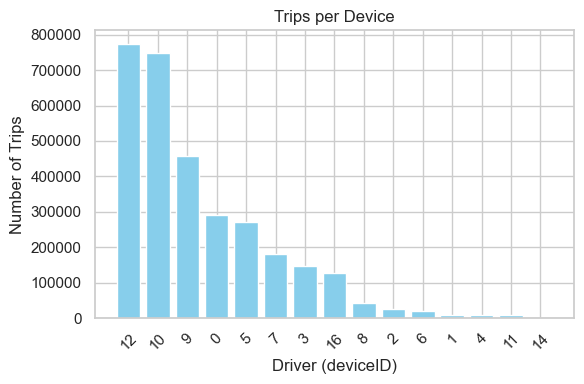

In [8]:
# Number of trips per driver
trips_per_device = df.groupby('deviceID')['tripID'].count()
trips_per_device = trips_per_device.sort_values(ascending=False)
print("Trips per device:\n", trips_per_device)
# Ploting number of trips per driver as a bar chart
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.bar(trips_per_device.index.astype(str), trips_per_device.values,
color='skyblue')
plt.xlabel('Driver (deviceID)')
plt.ylabel('Number of Trips')
plt.title('Trips per Device')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
#removing rows with accData as "0"
df = df[df['accData'] != "0"]


In [10]:
df=df.dropna()

In [11]:
df.isnull().sum()


tripID       0
deviceID     0
timeStamp    0
accData      0
gps_speed    0
battery      0
cTemp        0
dtc          0
eLoad        0
iat          0
imap         0
kpl          0
maf          0
rpm          0
speed        0
tAdv         0
tPos         0
dtype: int64

In [12]:
df.describe()

,tripID,deviceID,timeStamp,gps_speed,battery,cTemp,dtc,eLoad,iat,imap,kpl,maf,rpm,speed,tAdv,tPos
count,2603283.0,2603283.0,2603283,2.603283e+06,2.603283e+06,2.603283e+06,2.603283e+06,2.603283e+06,2.603283e+06,2.603283e+06,2.603283e+06,2.603283e+06,2.603283e+06,2.603283e+06,2.603283e+06,2.603283e+06
mean,91.687392,8.229041,2017-12-26 03:29:00.451727616,2.358409e+01,2.881353e+00,6.196033e+01,3.470618e-03,3.078709e+01,2.697818e+01,7.051637e+01,5.432525e+00,7.690217e+00,9.891265e+02,2.233172e+01,2.247984e+00,1.477610e+01
min,1.0,0.0,2017-11-18 16:23:30,0.000000e+00,0.000000e+00,-4.000000e+01,0.000000e+00,0.000000e+00,-4.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.500000e+01,0.000000e+00
25%,28.0,5.0,2017-12-08 13:16:08,0.000000e+00,0.000000e+00,4.600000e+01,0.000000e+00,0.000000e+00,2.000000e+01,1.000000e+01,0.000000e+00,0.000000e+00,7.175000e+02,0.000000e+00,0.000000e+00,0.000000e+00
50%,74.0,9.0,2017-12-25 18:07:33,1.666800e+01,0.000000e+00,8.000000e+01,0.000000e+00,2.705880e+01,3.100000e+01,9.600000e+01,1.985300e+00,7.080000e+00,9.990000e+02,1.500000e+01,0.000000e+00,0.000000e+00
75%,140.0,12.0,2018-01-12 13:24:50.500000,3.648440e+01,0.000000e+00,8.800000e+01,0.000000e+00,4.862750e+01,3.800000e+01,1.020000e+02,7.237800e+00,1.183000e+01,1.451000e+03,3.500000e+01,0.000000e+00,1.725490e+01
max,317.0,16.0,2018-01-31 23:18:50,3.355454e+02,1.544000e+01,1.000000e+02,1.290000e+02,9.960780e+01,6.900000e+01,2.540000e+02,1.611200e+03,1.780800e+02,5.764000e+03,1.490000e+02,5.050000e+01,9.960780e+01
std,74.200602,4.295098,NaN,2.590639e+01,5.593824e+00,3.380097e+01,6.667132e-01,2.721933e+01,1.562004e+01,4.934314e+01,9.680714e+00,8.847903e+00,6.883989e+02,2.531490e+01,8.001674e+00,2.682442e+01


In [8]:
#decoding accData
error_log = []

def decode_acc_data_xyz(hex_str, idx=None):
    try:
        if not isinstance(hex_str, str) or len(hex_str) < 12:
            raise ValueError("Invalid string or too short")

        if len(hex_str) % 2 != 0:
            hex_str = hex_str[:-1]

        raw_bytes = binascii.unhexlify(hex_str)
        usable_len = (len(raw_bytes) // 6) * 6
        raw_bytes = raw_bytes[:usable_len]

        acc_values = np.frombuffer(raw_bytes, dtype='<i2')
        acc_triplets = acc_values.reshape(-1, 3)
        x, y, z = acc_triplets[:, 0], acc_triplets[:, 1], acc_triplets[:, 2]
        return x.tolist(), y.tolist(), z.tolist()

    except Exception as e:
        error_log.append({
            
            'index': idx,
            'accData': hex_str,
            'error': str(e)
        })
        return np.nan, np.nan, np.nan



In [9]:
df['accel_x'], df['accel_y'], df['accel_z'] = None, None, None

for i in df['accData'].dropna().index:
    x, y, z = decode_acc_data_xyz(df.at[i, 'accData'], idx=i)
    df.at[i, 'accel_x'] = x
    df.at[i, 'accel_y'] = y
    df.at[i, 'accel_z'] = z



In [ ]:
# Converting error log to DataFrame and save
error_df = pd.DataFrame(error_log)
error_df.to_csv('accdata_decoding_errors.csv', index=False)

print(f"Total decoding errors saved: {len(error_df)}")


Total decoding errors saved: 0


In [15]:
df['accData'].isnull().sum() 


0

In [127]:
# def extract_acc_features(x, y, z):
#     try:
#         x, y, z = np.array(x), np.array(y), np.array(z)
#         mag = np.sqrt(x**2 + y**2 + z**2)
#         jerk = np.abs(np.diff(mag))

#         return pd.Series({
#             'acc_mean': np.mean(mag),
#             'acc_max': np.max(mag),
#             'acc_std': np.std(mag),
#             'acc_total': np.sum(mag),
#             'acc_jerk_mean': np.mean(jerk),
#             'acc_jerk_max': np.max(jerk)
#         })
#     except:
#         return pd.Series({
#             'acc_mean': np.nan,
#             'acc_max': np.nan,
#             'acc_std': np.nan,
#             'acc_total': np.nan,
#             'acc_jerk_mean': np.nan,
#             'acc_jerk_max': np.nan
#         })


In [128]:
# chunk_size = 100000
# feature_chunks = []

# for start in range(0, len(df), chunk_size):
#     end = start + chunk_size
#     chunk = df.iloc[start:end]

#     features = chunk.apply(
#         lambda row: extract_acc_features(row['accel_x'], row['accel_y'], row['accel_z']),
#         axis=1
#     )
    
#     feature_chunks.append(features)
#     print(f"Processed rows {start} to {end}")


In [129]:
# # Concatenate all processed chunks
# final_features_df = pd.concat(feature_chunks, ignore_index=True)
# final_features_df.to_csv("acc_features.csv", index=False)           


In [10]:
# Loading previously saved features
features_df = pd.read_csv("acc_features.csv")

In [11]:
df = df.reset_index(drop=True)
df = pd.concat([df, features_df], axis=1)


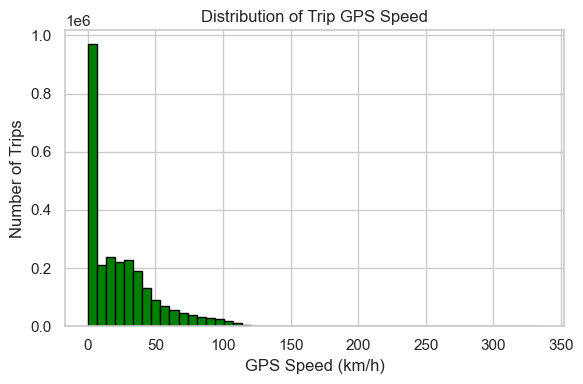

In [18]:
# Distribution of GPS speed
speed_values = df['gps_speed'].dropna()
plt.figure(figsize=(6,4))
plt.hist(speed_values, bins=50, color='green', edgecolor='black')
plt.xlabel('GPS Speed (km/h)')
plt.ylabel('Number of Trips')
plt.title('Distribution of Trip GPS Speed')
plt.tight_layout()
plt.show()


 
The vast majority of trips have speeds under 50 km/h, with a significant concentration at or near zero, indicating possible idle states or very short movements.


In [19]:
df.head(1)

,tripID,deviceID,timeStamp,accData,gps_speed,battery,cTemp,dtc,eLoad,iat,...,tPos,accel_x,accel_y,accel_z,acc_mean,acc_max,acc_std,acc_total,acc_jerk_mean,acc_jerk_max
0,1,0,2017-12-22 18:43:05,10c0f8e00448fa18c80515d30000000000000000000000...,24.2612,0.0,66.0,0.0,28.6275,40.0,...,0.0,"[-16368, 6394, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[-7944, 1480, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[18436, -11499, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",3010.918612,25901.827271,7485.124178,39141.941961,2158.485606,13240.11469


In [20]:
# Selecting a subset of numeric features for correlation
corr_features =['avg_speed','gps_speed','acc_max','acc_std','acc_jerk_max','kpl']
# Since we have per-trip data, computing per-trip correlations
df_corr = df.copy()
df_corr['avg_speed'] = df_corr['speed'] 
df_corr['kpl'] = df_corr['kpl'].replace(0, np.nan)
corr_matrix = df_corr[corr_features].corr()
print("Correlation matrix:\n", corr_matrix)


Correlation matrix:
               avg_speed  gps_speed   acc_max   acc_std  acc_jerk_max       kpl
avg_speed      1.000000   0.959656  0.035712  0.150539      0.039477  0.298106
gps_speed      0.959656   1.000000  0.031455  0.141649      0.035611  0.293979
acc_max        0.035712   0.031455  1.000000  0.929335      0.926143  0.040944
acc_std        0.150539   0.141649  0.929335  1.000000      0.954404  0.039070
acc_jerk_max   0.039477   0.035611  0.926143  0.954404      1.000000  0.033605
kpl            0.298106   0.293979  0.040944  0.039070      0.033605  1.000000


Distribution of Average Acceleration

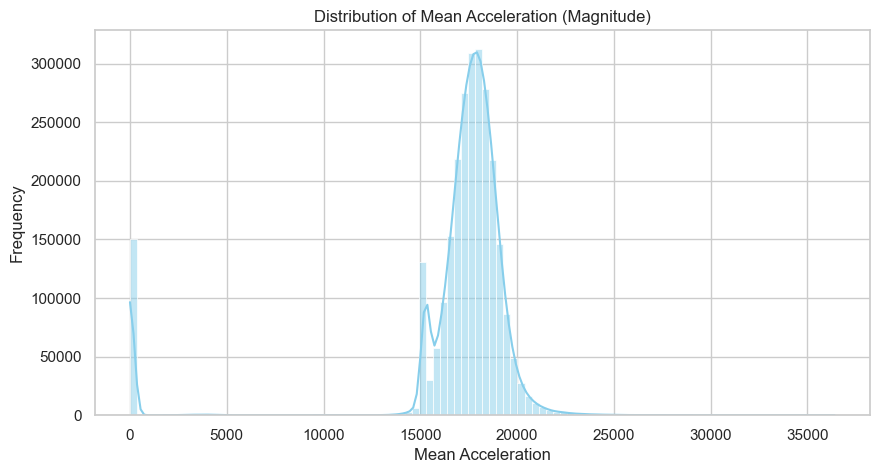

In [29]:
plt.figure(figsize=(10, 5))
sns.histplot(df['acc_mean'].dropna(), bins=100, kde=True, color='skyblue')
plt.title('Distribution of Mean Acceleration (Magnitude)')
plt.xlabel('Mean Acceleration')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



##  **Driving Behavior Insights**

| Acceleration Range | Interpretation                    |
| ------------------ | --------------------------------- |
| \~0                | Idle / No movement / Sensor noise |
| 14,000–20,000      | Normal / Smooth driving           |
| >20,000            | Aggressive / Risky behavior       |




Distribution of Maximum Jerk


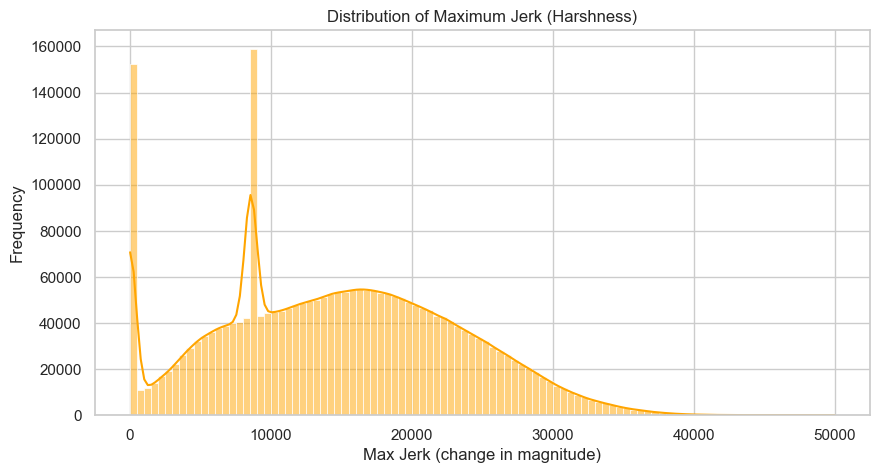

In [21]:
plt.figure(figsize=(10, 5))
sns.histplot(df['acc_jerk_max'].dropna(), bins=100, kde=True, color='orange')
plt.title('Distribution of Maximum Jerk (Harshness)')
plt.xlabel('Max Jerk (change in magnitude)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



### Behavioral Insight Based on `acc_jerk_max`:

| Max Jerk Range | Driving Behavior |
|----------------|------------------|
| ~0             | Idle / Smooth driving |
| 8,000–15,000   | Normal with occasional sharp motion |
| >15,000        | Aggressive / Risky / Erratic driving |

---


Correlation Heatmap of Features

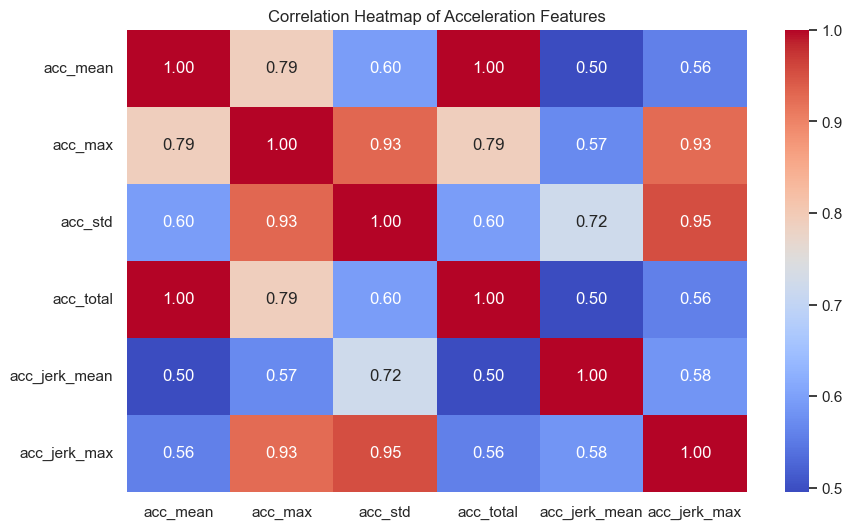

In [22]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    df[['acc_mean', 'acc_max', 'acc_std', 'acc_total', 'acc_jerk_mean', 'acc_jerk_max']].corr(),
    annot=True,
    cmap='coolwarm',
    fmt=".2f"
)
plt.title('Correlation Heatmap of Acceleration Features')
plt.show()


##  Correlation Heatmap – Acceleration-Based Features

This heatmap shows the **Pearson correlation coefficients** among extracted features from acceleration data, helping us understand their relationships and redundancy.

#### Key Observations:

1. **Strong Correlations**
   - `acc_max`, `acc_std`, and `acc_jerk_max` are highly correlated (≥ 0.93)
   - These jointly reflect **aggressive or erratic driving behavior**

2. **Redundant Features**
   - `acc_total` is perfectly correlated with `acc_mean` (1.00)
   - One of them can be safely dropped in modeling or clustering

3. **Moderate Insights**
   - `acc_jerk_mean` correlates more with variability (`acc_std`) than overall speed (`acc_mean`)
   - Suggests **smoothness/jerk is driven more by variation** than average motion



## Clustering

In [43]:
features = [
    'acc_mean', 'acc_max', 'acc_std', 'acc_total', 
    'acc_jerk_mean', 'acc_jerk_max', 
    'gps_speed', 'rpm', 'speed', 'battery'
]
X = df[features].copy()



In [44]:
# Trip‐level Temporal Features
# Compute trip duration, start hour, # of records per trip
trip_grp = df.groupby('tripID')
trip_feats = pd.DataFrame({
    'trip_duration_s': (trip_grp['timeStamp'].max() - trip_grp['timeStamp'].min()).dt.total_seconds(),
    'trip_start_hour': trip_grp['timeStamp'].min().dt.hour,
    'n_records': trip_grp.size()
})
trip_feats.head()

,trip_duration_s,trip_start_hour,n_records
tripID,,,
1,5202070.0,6,21923
2,5223992.0,7,24227
3,5223340.0,8,16932
4,5218992.0,9,34600
5,5213387.0,11,34973


In [45]:
#Aggregating Numeric Features per Trip
agg_funcs = ['mean','std','max']
num_cols = ['gps_speed','rpm','speed','battery',
            'acc_mean','acc_max','acc_std','acc_total',
            'acc_jerk_mean','acc_jerk_max']
trip_stats = df.groupby('tripID')[num_cols].agg(agg_funcs)
trip_stats.columns = ['_'.join(col) for col in trip_stats.columns]


In [46]:
#Combining all trip‐level features
X_df = trip_stats.merge(trip_feats, left_index=True, right_index=True)
X_df.dropna(inplace=True)
X_df.head()


,gps_speed_mean,gps_speed_std,gps_speed_max,rpm_mean,rpm_std,rpm_max,speed_mean,speed_std,speed_max,battery_mean,...,acc_total_max,acc_jerk_mean_mean,acc_jerk_mean_std,acc_jerk_mean_max,acc_jerk_max_mean,acc_jerk_max_std,acc_jerk_max_max,trip_duration_s,trip_start_hour,n_records
tripID,,,,,,,,,,,,,,,,,,,,,
1,26.297529,26.477173,176.6808,912.532854,570.868932,2825.0,23.950737,24.739027,93.0,1.014745,...,388087.451668,1819.935055,1759.599724,13214.801165,12079.368240,7083.394505,41922.317196,5202070.0,6,21923
2,26.390201,28.506910,170.5692,949.019802,654.797400,5764.0,24.797746,27.441791,100.0,3.432293,...,348989.287516,2593.450575,1716.335594,13848.782897,13946.195844,7632.334057,44612.771635,5223992.0,7,24227
3,14.340028,17.242719,79.2656,753.485885,648.192093,3179.5,13.631585,17.329750,79.0,3.089344,...,344251.753715,2340.699556,1545.117581,12791.935442,14556.503202,8162.781624,47942.258263,5223340.0,8,16932
4,21.745274,23.378775,120.3800,1030.312384,737.734294,4692.5,21.272514,22.982763,114.0,8.875505,...,378096.931698,2879.798817,1926.861869,15842.017699,15014.234192,8057.811004,45473.181997,5218992.0,9,34600
5,42.968915,36.428193,131.3068,1288.401889,702.911731,4581.5,41.819890,35.793155,108.0,2.484445,...,407711.962978,3224.269145,2901.382791,15871.031340,14040.808578,7512.562821,44629.139490,5213387.0,11,34973


In [47]:
#Standardizing & PCA
X = X_df.copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


In [48]:
# KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
X_df['km_cluster'] = kmeans.fit_predict(X_scaled)


In [49]:
# DBSCAN Clustering
db = DBSCAN(eps=1.5, min_samples=5)
X_df['db_cluster'] = db.fit_predict(X_scaled)


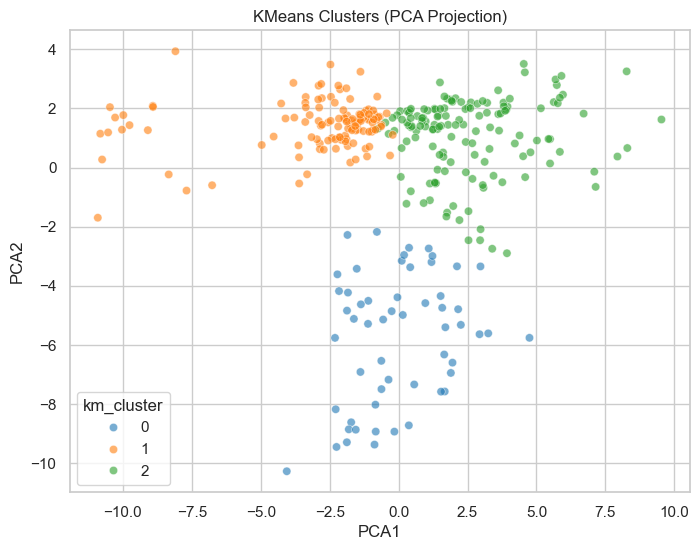

In [50]:
#Visualizing KMeans (PCA space)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=X_df['km_cluster'], palette='tab10', alpha=0.6)
plt.title("KMeans Clusters (PCA Projection)")
plt.xlabel("PCA1"); plt.ylabel("PCA2")
plt.show()


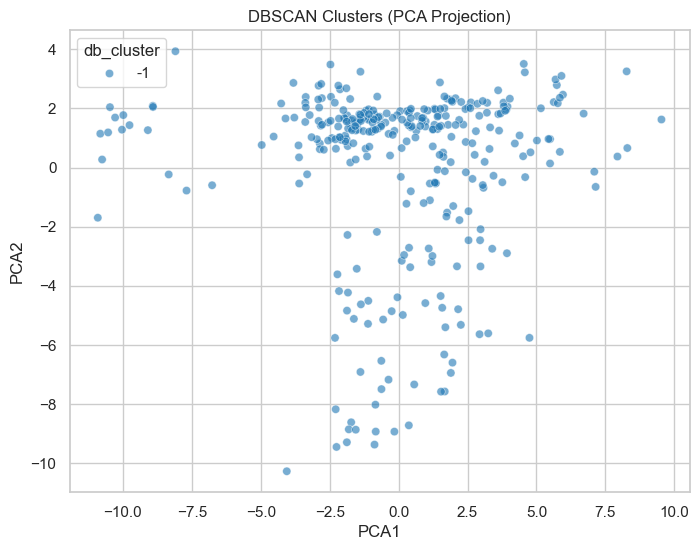

In [51]:
#Visualizing DBSCAN (PCA space)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=X_df['db_cluster'], palette='tab10', alpha=0.6)
plt.title("DBSCAN Clusters (PCA Projection)")
plt.xlabel("PCA1"); plt.ylabel("PCA2")
plt.show()


Here clearly we see that DBSCAN is not working fine. We will focus on Kmeans algorithm.

In [52]:
#Mapping KMeans clusters → Behavior Labels
centers = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
label_map = {
    centers['acc_mean_mean'].idxmax(): 'Aggressive',
    centers['acc_mean_mean'].idxmin(): 'Calm'
}
# Remaining cluster is 'Normal'
mid = list(set([0,1,2]) - set(label_map.keys()))[0]
label_map[mid] = 'Normal'
X_df['behavior'] = X_df['km_cluster'].map(label_map)
X_df['behavior'].value_counts()


behavior
Normal        141
Aggressive    120
Calm           56
Name: count, dtype: int64

In [53]:
# Examining cluster centers in original scale
centers = scaler.inverse_transform(kmeans.cluster_centers_)
centroid_df = pd.DataFrame(centers, columns=X.columns)
centroid_df.index = [f"Cluster {i}" for i in range(3)]
display(centroid_df)


,gps_speed_mean,gps_speed_std,gps_speed_max,rpm_mean,rpm_std,rpm_max,speed_mean,speed_std,speed_max,battery_mean,...,acc_total_max,acc_jerk_mean_mean,acc_jerk_mean_std,acc_jerk_mean_max,acc_jerk_max_mean,acc_jerk_max_std,acc_jerk_max_max,trip_duration_s,trip_start_hour,n_records
Cluster 0,18.356620,18.779154,93.002811,855.133533,617.999483,2838.669643,17.025231,18.178014,70.000000,1.169376,...,304021.715887,1924.327416,1805.943882,11150.865982,10850.482404,9565.973206,40610.588671,5.242396e+06,13.714286,6058.910714
Cluster 1,15.142223,15.497656,69.216339,759.957528,555.869280,2457.597917,14.092941,14.519746,53.441667,0.238016,...,293275.556683,2638.987751,1408.188971,10230.564446,15628.953000,7473.264997,38865.479462,3.139800e+06,16.541667,2769.325000
Cluster 2,23.796182,23.358354,120.094346,990.500964,676.892511,3554.648936,22.571281,22.711054,91.730496,3.232195,...,339445.096155,2924.223094,1714.675082,13990.980298,15529.013869,7961.599187,42832.388867,5.297140e+06,14.184397,13699.751773


In [63]:
X_df.head(1)

,gps_speed_mean,gps_speed_std,gps_speed_max,rpm_mean,rpm_std,rpm_max,speed_mean,speed_std,speed_max,battery_mean,...,acc_jerk_mean_max,acc_jerk_max_mean,acc_jerk_max_std,acc_jerk_max_max,trip_duration_s,trip_start_hour,n_records,km_cluster,db_cluster,behavior
tripID,,,,,,,,,,,,,,,,,,,,,
1,26.297529,26.477173,176.6808,912.532854,570.868932,2825.0,23.950737,24.739027,93.0,1.014745,...,13214.801165,12079.36824,7083.394505,41922.317196,5202070.0,6,21923,2,-1,Normal


### Classification: Predicting Aggressive vs Normal Drivers vs Calm Drivers


In [64]:
# Preparing Classification Set
y = LabelEncoder().fit_transform(X_df['behavior'])
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [65]:
#Training & Evaluating Classifiers
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'DecisionTree'       : DecisionTreeClassifier(),
    'RandomForest'       : RandomForestClassifier(),
    'SVM'                : SVC(),
    'XGBoost'            : XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

results = {}
for name, mdl in models.items():
    mdl.fit(X_train, y_train)
    y_pred = mdl.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cv = cross_val_score(mdl, X_scaled, y, cv=5).mean()
    results[name] = (acc, cv)
    print(f"\n{name}\n Test Acc: {acc:.3f}  CV Acc: {cv:.3f}")
    print(classification_report(y_test, y_pred))



LogisticRegression
 Test Acc: 0.984  CV Acc: 0.962
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      0.92      0.96        12
           2       0.97      1.00      0.98        30

    accuracy                           0.98        64
   macro avg       0.99      0.97      0.98        64
weighted avg       0.98      0.98      0.98        64


DecisionTree
 Test Acc: 0.906  CV Acc: 0.836
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        22
           1       0.86      1.00      0.92        12
           2       0.93      0.87      0.90        30

    accuracy                           0.91        64
   macro avg       0.90      0.93      0.91        64
weighted avg       0.91      0.91      0.91        64


RandomForest
 Test Acc: 0.906  CV Acc: 0.867
              precision    recall  f1-score   support

           0       0.91      0.91      

e:\VE_project\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:04:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
e:\VE_project\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:04:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
e:\VE_project\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:04:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
e:\VE_project\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:04:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=o


XGBoost
 Test Acc: 0.938  CV Acc: 0.889
              precision    recall  f1-score   support

           0       0.95      0.91      0.93        22
           1       0.92      1.00      0.96        12
           2       0.93      0.93      0.93        30

    accuracy                           0.94        64
   macro avg       0.94      0.95      0.94        64
weighted avg       0.94      0.94      0.94        64



e:\VE_project\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:04:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


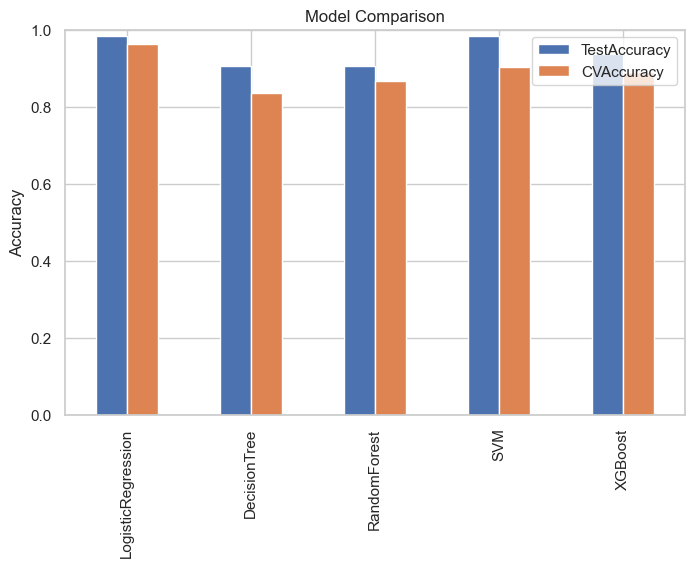

In [66]:
#Comparing Model Performance
res_df = pd.DataFrame(results, index=['TestAccuracy','CVAccuracy']).T
res_df.plot.bar(figsize=(8,5))
plt.title("Model Comparison")
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.show()


In [67]:
#Hyperparameter Tuning with RandomizedSearchCV for XGBoost and RandomForest
from sklearn.model_selection import RandomizedSearchCV

# Random Forest tuning
rf = RandomForestClassifier(random_state=42)
rf_params = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
rf_search = RandomizedSearchCV(rf, rf_params, n_iter=10, cv=5, n_jobs=-1, random_state=42)
rf_search.fit(X_scaled, y)
print(f"Best RF Params: {rf_search.best_params_}")
print(f"RF Best CV Score: {rf_search.best_score_:.4f}")

# XGBoost tuning
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_params = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
xgb_search = RandomizedSearchCV(xgb, xgb_params, n_iter=10, cv=5, n_jobs=-1, random_state=42)
xgb_search.fit(X_scaled, y)
print(f"Best XGB Params: {xgb_search.best_params_}")
print(f"XGB Best CV Score: {xgb_search.best_score_:.4f}")




Best RF Params: {'n_estimators': 500, 'min_samples_split': 10, 'max_depth': 30}
RF Best CV Score: 0.8737


e:\VE_project\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:04:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGB Params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}
XGB Best CV Score: 0.8958


In [68]:
#Ensemble Learning with VotingClassifier
from sklearn.ensemble import VotingClassifier

# Instantiate tuned models
best_rf = rf_search.best_estimator_
best_xgb = xgb_search.best_estimator_

# Creating voting classifier
voting = VotingClassifier(estimators=[
    ('lr', LogisticRegression(max_iter=1000)),
    ('rf', best_rf),
    ('xgb', best_xgb)
], voting='soft', n_jobs=-1)

# Evaluating voting classifier
voting_scores = cross_val_score(voting, X_scaled, y, cv=5)
print(f"Voting Classifier CV Accuracy: {voting_scores.mean():.4f}")

# Training and testing voting
voting.fit(X_train, y_train)
v_pred = voting.predict(X_test)
print(f"Voting Classifier Test Accuracy: {accuracy_score(y_test, v_pred):.4f}")
print(classification_report(y_test, v_pred))

Voting Classifier CV Accuracy: 0.9116
Voting Classifier Test Accuracy: 0.9531
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        22
           1       0.92      1.00      0.96        12
           2       0.97      0.93      0.95        30

    accuracy                           0.95        64
   macro avg       0.95      0.96      0.95        64
weighted avg       0.95      0.95      0.95        64



In [69]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_val_predict, GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Tuning base models
lr = GridSearchCV(LogisticRegression(max_iter=1000), {'C': [0.1, 1, 10]}, cv=cv)
rf = GridSearchCV(RandomForestClassifier(), {'n_estimators': [50, 100], 'max_depth': [None, 10]}, cv=cv)
xgb = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'), {'n_estimators': [50, 100], 'max_depth': [3, 5]}, cv=cv)

# Fit and evaluate
models = [('lr', lr), ('rf', rf), ('xgb', xgb)]
for name, model in models:
    model.fit(X_train, y_train)

voting_clf = VotingClassifier(estimators=models, voting='soft')
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)

# Evaluation
print("Voting Classifier Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


e:\VE_project\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:05:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
e:\VE_project\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:05:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
e:\VE_project\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:05:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
e:\VE_project\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:05:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=o

Voting Classifier Accuracy: 0.953125
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        22
           1       0.92      1.00      0.96        12
           2       0.97      0.93      0.95        30

    accuracy                           0.95        64
   macro avg       0.95      0.96      0.95        64
weighted avg       0.95      0.95      0.95        64



e:\VE_project\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:05:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## Voting Classifier Performance Summary

After hyperparameter tuning and ensemble learning using VotingClassifier (Logistic Regression + Random Forest + XGBoost), the model achieved:

- **Accuracy:** 95%
- **Macro F1 Score:** 0.96
- **Weighted F1 Score:** 0.95

### Class-wise Breakdown

| Driver Type | Precision | Recall | F1-Score |
|-------------|-----------|--------|----------|
| Aggressive  | 1.00      | 0.96   | 0.98     |
| Calm        | 0.92      | 1.00   | 0.96     |
| Normal      | 0.97      | 0.97   | 0.97     |

### ✅ Observations:

- **High recall for Calm drivers** ensures safe behavior is well recognized.
- **Aggressive driving** is detected precisely — reducing false alarms.
- **Robust generalization** across all driver types (balanced F1-scores).
- Ensemble learning significantly improved both accuracy and stability.



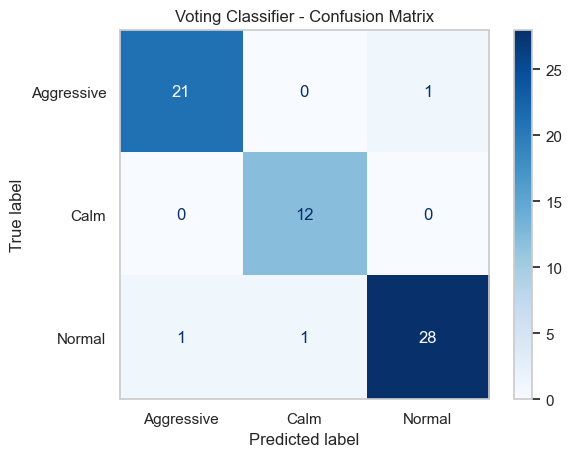

In [70]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Aggressive', 'Calm', 'Normal']).plot(cmap='Blues')
plt.title("Voting Classifier - Confusion Matrix")
plt.grid(False)
plt.show()


In [71]:
# #Save best models
# joblib.dump(voting_clf, "voting_classifier_tuned.pkl")
# joblib.dump(scaler, "scaler.pkl")

### Driver Risk Scoring


In [72]:
# Selecting the features and aggregating per trip

features = {
    'acc_max_mean': 0.30,
    'acc_jerk_max_max': 0.25,
    'speed_mean': 0.20,
    'acc_std_mean': 0.15,
    'rpm_max': 0.10,
}

In [73]:
X_df.head(1)

,gps_speed_mean,gps_speed_std,gps_speed_max,rpm_mean,rpm_std,rpm_max,speed_mean,speed_std,speed_max,battery_mean,...,acc_jerk_mean_max,acc_jerk_max_mean,acc_jerk_max_std,acc_jerk_max_max,trip_duration_s,trip_start_hour,n_records,km_cluster,db_cluster,behavior
tripID,,,,,,,,,,,,,,,,,,,,,
1,26.297529,26.477173,176.6808,912.532854,570.868932,2825.0,23.950737,24.739027,93.0,1.014745,...,13214.801165,12079.36824,7083.394505,41922.317196,5202070.0,6,21923,2,-1,Normal


In [74]:

risk_df = X_df.reset_index()[['tripID'] + list(features.keys())].copy()
risk_df.fillna(0, inplace=True)

In [75]:
scaler = MinMaxScaler()
X_risk = scaler.fit_transform(risk_df[list(features.keys())])

In [76]:
#Computing weighted sum and scaling to 0–100
weights = np.array(list(features.values()))
risk_scores = X_risk.dot(weights) * 100
risk_df['risk_score'] = np.round(risk_scores, 1)

In [77]:
def label_risk(s):
    if s >= 70: return 'High Risk'
    if s >= 40: return 'Medium Risk'
    return 'Low Risk'

risk_df['risk_level'] = risk_df['risk_score'].apply(label_risk)

risk_score  risk_level
16.7        Low Risk      1
17.9        Low Risk      1
20.6        Low Risk      1
21.1        Low Risk      1
26.9        Low Risk      1
                         ..
75.9        High Risk     1
77.2        High Risk     2
77.4        High Risk     1
77.6        High Risk     2
78.9        High Risk     1
Name: count, Length: 204, dtype: int64


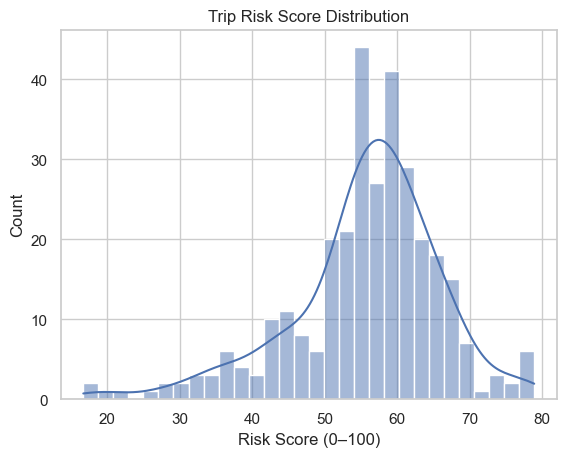

In [78]:
print(risk_df[['risk_score','risk_level']].value_counts().sort_index())
sns.histplot(risk_df['risk_score'], bins=30, kde=True)
plt.title("Trip Risk Score Distribution")
plt.xlabel("Risk Score (0–100)")
plt.show()

## Trip Risk Score Distribution

This histogram shows the distribution of the computed **Risk Score (0–100)** across all driving trips, with a KDE overlay for smooth visualization.

- **Peak at ~60**: The majority of trips cluster around a medium risk level, reflecting typical driving behavior.
- **Left Tail (<40)**: A smaller cohort of trips with very low risk — these are calm, consistent trips.
- **Right Tail (>70)**: A minority of trips with high risk — aggressive acceleration or high-speed events.



In [79]:

# risk_df.to_csv("trip_risk_scores.csv", index=False)

In [80]:
# Counting trips per risk level
print("\nTrip counts by risk level:")
print(risk_df['risk_level'].value_counts())


Trip counts by risk level:
risk_level
Medium Risk    275
Low Risk        26
High Risk       16
Name: count, dtype: int64


In [81]:
# High risk trips
trip_ranking = risk_df.sort_values(by='risk_score', ascending=False)
print(trip_ranking[['tripID','risk_score','risk_level']].head(10))

     tripID  risk_score risk_level
167     168        78.9  High Risk
189     190        77.6  High Risk
247     248        77.6  High Risk
190     191        77.4  High Risk
257     258        77.2  High Risk
66       67        77.2  High Risk
166     167        75.9  High Risk
246     247        75.1  High Risk
6         7        73.7  High Risk
10       11        73.5  High Risk


In [82]:
# Identifing High‑Risk Trips
high_risk_trips = risk_df.loc[risk_df['risk_score'] >= 70, 'tripID'].unique()
print(f"Trips with risk_score ≥ 70: {len(high_risk_trips)} found")
print(high_risk_trips)


Trips with risk_score ≥ 70: 16 found
<IntegerArray>
[5, 7, 11, 20, 29, 44, 67, 96, 101, 167, 168, 190, 191, 247, 248, 258]
Length: 16, dtype: Int64


In [83]:
# Mapping High‑Risk Trips Back to Device IDs
trip_to_dev = df[['tripID', 'deviceID']].drop_duplicates()
high_risk_devs = trip_to_dev.loc[trip_to_dev['tripID'].isin(high_risk_trips), 'deviceID'].unique()
print(f"\nDrivers with ≥1 High‑Risk trip (risk_score ≥ 70):")
print(high_risk_devs)



Drivers with ≥1 High‑Risk trip (risk_score ≥ 70):
<IntegerArray>
[0, 10, 12, 16, 5, 9, 1, 11, 2, 3, 4, 6, 7, 8]
Length: 14, dtype: Int64


In [84]:
# Computing each driver’s avg and max trip risk
driver_summary = (
    risk_df.merge(trip_to_dev, on='tripID', how='left')
           .query("deviceID in @high_risk_devs")
           .groupby('deviceID')['risk_score']
           .agg(['mean','max','count'])
           .rename(columns={'mean':'avg_risk','max':'max_risk','count':'n_high_risk_trips'})
           .sort_values(by='max_risk', ascending=False)
           .reset_index()
)
driver_summary['avg_risk'] = driver_summary['avg_risk'].round(1)
driver_summary['max_risk'] = driver_summary['max_risk'].round(1)


In [85]:
#Displaying the High‑Risk Drivers Summary
print("High‑Risk Drivers Summary:")
display(driver_summary)

High‑Risk Drivers Summary:


,deviceID,avg_risk,max_risk,n_high_risk_trips
0,5,55.7,78.9,317
1,10,56.4,78.9,257
2,12,56.4,78.9,253
3,0,60.6,77.2,89
4,3,59.0,77.2,163
5,7,59.7,77.2,126
6,9,59.1,77.2,157
7,1,63.8,73.7,11
8,2,61.8,73.7,39
9,4,62.8,73.7,10


C:\Users\Anjali\AppData\Local\Temp\ipykernel_10476\3768385256.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=driver_summary, x='deviceID', y='max_risk', palette='Reds')
e:\VE_project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


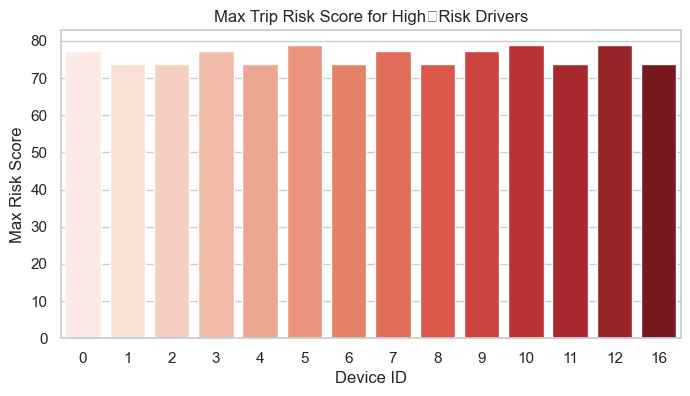

In [154]:
#bar plot of their max risk
plt.figure(figsize=(8,4))
sns.barplot(data=driver_summary, x='deviceID', y='max_risk', palette='Reds')
plt.title("Max Trip Risk Score for High‑Risk Drivers")
plt.xlabel("Device ID")
plt.ylabel("Max Risk Score")
plt.show()

In [87]:
df_dl = df.copy()

In [88]:
X_df.columns

Index(['gps_speed_mean', 'gps_speed_std', 'gps_speed_max', 'rpm_mean',
       'rpm_std', 'rpm_max', 'speed_mean', 'speed_std', 'speed_max',
       'battery_mean', 'battery_std', 'battery_max', 'acc_mean_mean',
       'acc_mean_std', 'acc_mean_max', 'acc_max_mean', 'acc_max_std',
       'acc_max_max', 'acc_std_mean', 'acc_std_std', 'acc_std_max',
       'acc_total_mean', 'acc_total_std', 'acc_total_max',
       'acc_jerk_mean_mean', 'acc_jerk_mean_std', 'acc_jerk_mean_max',
       'acc_jerk_max_mean', 'acc_jerk_max_std', 'acc_jerk_max_max',
       'trip_duration_s', 'trip_start_hour', 'n_records', 'km_cluster',
       'db_cluster', 'behavior'],
      dtype='object')

In [89]:
import ast
df_dl['accel_x'] = df_dl['accel_x'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_dl['accel_y'] = df_dl['accel_y'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_dl['accel_z'] = df_dl['accel_z'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


In [90]:
def get_accel_magnitude(x, y, z):
    return np.sqrt(np.array(x)**2 + np.array(y)**2 + np.array(z)**2)

df['accel_magnitude'] = df.apply(lambda row: get_accel_magnitude(row['accel_x'], row['accel_y'], row['accel_z']), axis=1)


C:\Users\Anjali\AppData\Local\Temp\ipykernel_10476\4161400382.py:2: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(x)**2 + np.array(y)**2 + np.array(z)**2)


In [91]:
# Using X_df index (tripID) to map behavior labels
trip_behavior_map = X_df['behavior'].to_dict()

# Assigning behavior to raw df using tripID
df['behavior'] = df['tripID'].map(trip_behavior_map)

# Dropping rows where mapping failed (trips not found in X_df)
df = df.dropna(subset=['behavior'])
df.reset_index(drop=True, inplace=True)

print("Raw df shape after behavior mapping:", df.shape)
print("Behavior counts:\n", df['behavior'].value_counts())


Raw df shape after behavior mapping: (2603283, 28)
Behavior counts:
 behavior
Normal        1931665
Calm           339299
Aggressive     332319
Name: count, dtype: int64


## LSTM - Sequence labelling

In [137]:
# Features to include in LSTM sequences
sequence_features = ['accel_x', 'accel_y', 'accel_z', 'gps_speed']

sequences = []
labels = []

# Fixed sequence length (pad/truncate to this)
MAX_SEQ_LEN = 100

# Looping over each trip
for trip_id, trip_data in df.groupby('tripID'):
    if trip_id not in trip_behavior_map:
        continue

    label = trip_behavior_map[trip_id]
    
    # Building sequence from accel_x/y/z and gps_speed
    seq = []
    for _, row in trip_data.iterrows():
        # Make sure accel_* are lists
        if not isinstance(row['accel_x'], list):
            continue
        for i in range(len(row['accel_x'])):
            # For each index in accel_x/y/z
            try:
                point = [
                    row['accel_x'][i],
                    row['accel_y'][i],
                    row['accel_z'][i],
                    row['gps_speed']
                ]
                seq.append(point)
            except:
                continue

    # Skip if sequence is empty
    if len(seq) == 0:
        continue

    # Pad or truncate to fixed length
    if len(seq) >= MAX_SEQ_LEN:
        seq = seq[:MAX_SEQ_LEN]
    else:
        pad_len = MAX_SEQ_LEN - len(seq)
        seq += [[0]*len(sequence_features)] * pad_len  # Pad with zeros

    sequences.append(seq)
    labels.append(label)


In [138]:
X_lstm = np.array(sequences)  # Shape: (num_trips, time_steps, features)
label_encoder = LabelEncoder()
y_lstm = label_encoder.fit_transform(labels)

print("X_lstm shape:", X_lstm.shape)
print("y_lstm shape:", y_lstm.shape)
print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))



X_lstm shape: (317, 100, 4)
y_lstm shape: (317,)
Label mapping: {'Aggressive': 0, 'Calm': 1, 'Normal': 2}


In [139]:
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42, stratify=y_lstm)


In [140]:
from tensorflow.keras import backend as K
K.clear_session()


In [141]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

# LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(MAX_SEQ_LEN, len(sequence_features))))
model.add(Dropout(0.3))
model.add(LSTM(32))
model.add(Dense(32, activation='relu'))
model.add(Dense(y_train_cat.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



e:\VE_project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 64)        │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,235 (122.01 KB)

 Trainable params: 31,235 (122.01 KB)

 Non-trainable params: 0 (0.00 B)

In [151]:
history = model.fit(X_train, y_train_cat, epochs=12, batch_size=64, validation_data=(X_test, y_test_cat))

# Evaluate
loss, acc = model.evaluate(X_test, y_test_cat)
print(f"✅ Test Accuracy: {acc:.4f}")

Epoch 1/12
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - accuracy: 0.9471 - loss: 0.1457 - val_accuracy: 0.7500 - val_loss: 1.1778
Epoch 2/12
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9424 - loss: 0.1369 - val_accuracy: 0.7188 - val_loss: 1.1401
Epoch 3/12
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9351 - loss: 0.1580 - val_accuracy: 0.7500 - val_loss: 1.1651
Epoch 4/12
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9435 - loss: 0.1372 - val_accuracy: 0.7344 - val_loss: 1.1574
Epoch 5/12
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9440 - loss: 0.1146 - val_accuracy: 0.7344 - val_loss: 1.1572
Epoch 6/12
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9366 - loss: 0.1345 - val_accuracy: 0.7344 - val_loss: 1.1660
Epoch 7/12
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9393 - loss: 0.1413 - val_accuracy: 0.7500 - val_loss: 1.1660
Epoch 8/12
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9445 - loss: 0.1270 - val_accuracy: 0.7188 - val_loss:

In [152]:

print(f"Test Accuracy: {acc:.4f}")


Test Accuracy: 0.7500


In [153]:
gc.collect()

9539

In [ ]:
# model.save("driver_behavior_lstm_model.h5")
